In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import shap
import matplotlib.pyplot as plt


c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load dataset
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert and clean target variable
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")
df.dropna(subset=["Survival_from_surgery_days_UPDATED"], inplace=True)

# Binning into categories
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [25, 50, 75])
bins = [0, percentiles[0], percentiles[1], percentiles[2], np.inf]
labels = [0, 1, 2, 3]
df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Prepare features and labels
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Encode categorical features
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Fill missing and scale
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

C:\Users\asp61\AppData\Local\Temp\ipykernel_42972\3262085688.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [3]:

# LDA for visualization & base training (optional)
lda = LinearDiscriminantAnalysis(n_components=3)
X_lda = lda.fit_transform(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.1, random_state=42, stratify=y)

# Balance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Base Models
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
log_reg = LogisticRegression(max_iter=1000)
lda_clf = LinearDiscriminantAnalysis()

# Ensemble and Stacking
voting_clf = VotingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    voting="hard"
)

stacking_clf = StackingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    final_estimator=RandomForestClassifier()
)

In [4]:

# 10-Fold Cross Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("Cross-validation scores:")
for model_name, model in [("Voting Classifier", voting_clf), ("Stacking Classifier", stacking_clf)]:
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"{model_name} Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Final training on full training set
voting_clf.fit(X_train, y_train)
stacking_clf.fit(X_train, y_train)

# Final evaluation
y_pred_voting = voting_clf.predict(X_test)
y_pred_stacking = stacking_clf.predict(X_test)

print("\nVoting Classifier Test Report:")
print(classification_report(y_test, y_pred_voting))

print("\nStacking Classifier Test Report:")
print(classification_report(y_test, y_pred_stacking))

Cross-validation scores:


c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:46:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:46:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Voting Classifier Accuracy: 0.952 ± 0.031


c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:46:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Stacking Classifier Accuracy: 0.952 ± 0.020


c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are


Voting Classifier Test Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        16

    accuracy                           0.98        65
   macro avg       0.99      0.98      0.98        65
weighted avg       0.99      0.98      0.98        65


Stacking Classifier Test Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.94      0.97        16
           2       1.00      0.94      0.97        16
           3       1.00      1.00      1.00        16

    accuracy                           0.97        65
   macro avg       0.97      0.97      0.97        65
weighted avg       0.97      0.97      0.97        65



In [9]:
## THe 7 seconds one
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load dataset
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Percentile-Based Binning
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [25,50,75])
bins = [0, percentiles[0], percentiles[1],  percentiles[2], np.inf]
labels = [0, 1, 2,3]

df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features (X) and target (y)
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Filter X to include only these features
top_100_features = importance_df.head(420)['Feature'].tolist()
X = X[top_100_features]

# Encode categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Fill missing numeric values with median
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply LDA for dimensionality reduction
lda = LinearDiscriminantAnalysis(n_components=3)  # Adjust components based on the number of classes - 1
X_lda = lda.fit_transform(X_scaled, y)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.1, random_state=42, stratify=y)

# Balance Classes with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define Base Models
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
log_reg = LogisticRegression(max_iter=1000)
lda_clf = LinearDiscriminantAnalysis()

# Voting Classifier (Soft Voting for Probabilistic Averaging)
ensemble_model = VotingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    voting="soft"
)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    final_estimator=RandomForestClassifier()
)

# Train the models
stacking_clf.fit(X_train, y_train)
ensemble_model.fit(X_train, y_train)

# Predictions
y_pred_ensemble = ensemble_model.predict(X_test)
y_pred_stacking = stacking_clf.predict(X_test)

# Evaluate the models
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)

report_ensemble = classification_report(y_test, y_pred_ensemble)
report_stacking = classification_report(y_test, y_pred_stacking)

print(f"Ensemble Model Accuracy with LDA: {accuracy_ensemble:.2f}")
print("Classification Report:\n", report_ensemble)

print(f"Stacking Model Accuracy with LDA: {accuracy_stacking:.2f}")
print("Classification Report:\n", report_stacking)

C:\Users\asp61\AppData\Local\Temp\ipykernel_42972\587367232.py:18: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Ensemble Model Accuracy with LDA: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        16

    accuracy                           0.98        65
   macro avg       0.99      0.98      0.98        65
weighted avg       0.99      0.98      0.98        65

Stacking Model Accuracy with LDA: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        16

    accuracy                           0.98        65
   macro avg       0.99      0.98      0.98        65
weighted avg       0.99      0.98      0.98        65



In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the target labels (necessary for multi-class AUC calculation)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Modify based on your actual class labels
n_classes = y_test_bin.shape[1]

# For Ensemble Model - predict probabilities
y_prob_ensemble = ensemble_model.predict_proba(X_test)

# For Stacking Model - predict probabilities
y_prob_stacking = stacking_clf.predict_proba(X_test)

# Calculate AUC-ROC for each model (for multi-class, we calculate AUC for each class)
auc_roc_ensemble = roc_auc_score(y_test_bin, y_prob_ensemble, average="macro", multi_class="ovr")
auc_roc_stacking = roc_auc_score(y_test_bin, y_prob_stacking, average="macro", multi_class="ovr")

# Output AUC-ROC scores
print(f"AUC-ROC for Ensemble Model: {auc_roc_ensemble:.2f}")
print(f"AUC-ROC for Stacking Model: {auc_roc_stacking:.2f}")


AUC-ROC for Ensemble Model: 1.00
AUC-ROC for Stacking Model: 1.00


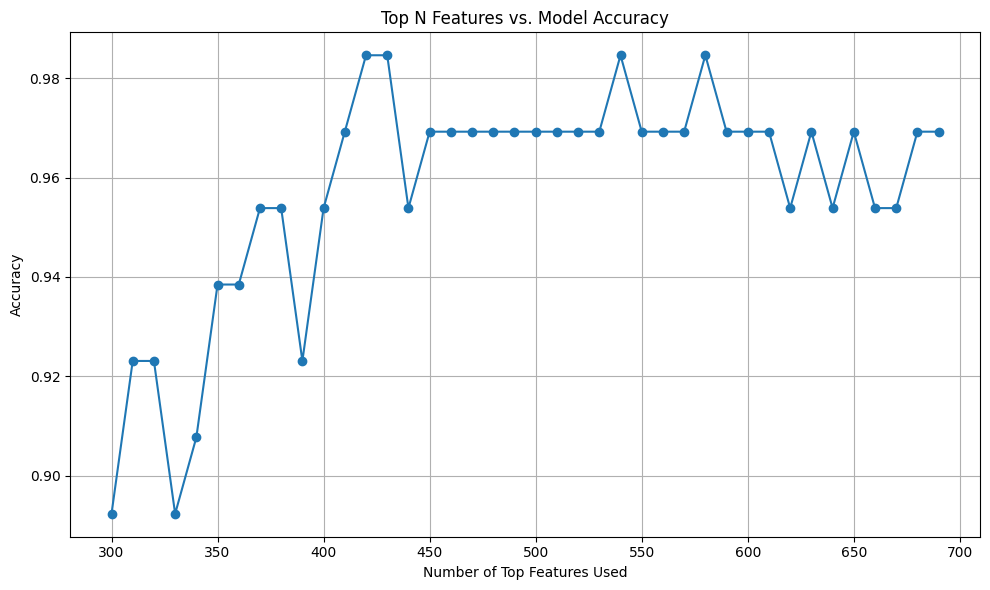

In [ ]:
import matplotlib.pyplot as plt
accuracies = []
feature_counts = list(range(300, 700, 10))  # e.g., 50, 100, ..., 350

for n in feature_counts:
    top_n_features = importance_df.head(n)['Feature'].tolist()
    X_subset = df[top_n_features].copy()

    # Encode categorical
    for col in X_subset.select_dtypes(include=["object"]).columns:
        le = LabelEncoder()
        X_subset[col] = le.fit_transform(X_subset[col].astype(str))

    # Fill and scale
    X_subset = X_subset.apply(pd.to_numeric, errors="coerce").fillna(X_subset.median())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_subset)

    # Target
    y = df["Survival_Category"]

    # LDA
    lda = LinearDiscriminantAnalysis(n_components=3)
    X_lda = lda.fit_transform(X_scaled, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.1, stratify=y, random_state=42)

    # SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Model (stacking or voting — just pick one for this comparison)
    base_models = [
        ("RandomForest", RandomForestClassifier(n_estimators=150, random_state=42)),
        ("XGBoost", xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)),
        ("LogReg", LogisticRegression(max_iter=1000)),
        ("LDA", LinearDiscriminantAnalysis())
    ]

    stacking_clf = StackingClassifier(
        estimators=base_models,
        final_estimator=RandomForestClassifier()
    )

    # Train and evaluate
    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, accuracies, marker='o')
plt.title("Top N Features vs. Model Accuracy")
plt.xlabel("Number of Top Features Used")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
feature_names = X.columns

# Take absolute value and sum across discriminants
lda_feature_importance = np.abs(lda.coef_).sum(axis=0)

# Create a DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": lda_feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print(importance_df.head(50))

                                                Feature  Importance
1                                     Age_at_scan_years   17.927916
4                                                  IDH1   13.444819
5                                                  MGMT   12.917231
0                                                Gender    8.627960
3815  T1GD_NC_Histogram_Bins-16_Bins-16_MeanAbsolute...    6.333860
4103  T1_ET_Histogram_Bins-16_Bins-16_MeanAbsoluteDe...    6.306016
8                             Time_since_baseline_preop    6.056273
4453   T2_ED_GLSZM_Bins-16_Radius-1_GreyLevelVariance_x    5.768656
2896        DTI_TR_NC_Intensity_MeanAbsoluteDeviation_x    5.388300
1264  DSC_PSR_NC_GLCM_Bins-16_Radius-1_AutoCorrelati...    5.248733
3184         FLAIR_ET_Intensity_MeanAbsoluteDeviation_x    5.189719
3243          FLAIR_ET_Histogram_Bins-16_Bins-16_Mode_x    5.075271
7                                     GTR_over90percent    5.037397
3733  T1GD_ET_GLSZM_Bins-16_Radius-1_GreyLevelVa

In [ ]:
from sklearn.metrics import balanced_accuracy_score

# Balanced Accuracy
balanced_acc_ensemble = balanced_accuracy_score(y_test, y_pred_ensemble)
balanced_acc_stacking = balanced_accuracy_score(y_test, y_pred_stacking)

print(f"Balanced Accuracy (Ensemble): {balanced_acc_ensemble:.2f}")
print(f"Balanced Accuracy (Stacking): {balanced_acc_stacking:.2f}")


Balanced Accuracy (Ensemble): 0.96
Balanced Accuracy (Stacking): 0.96


In [ ]:
from lifelines.utils import concordance_index

# Get original survival times for y_test samples
# Make sure the test set index aligns with the original dataframe
true_survival_times = y_test.copy()
true_survival_times = df.loc[y_test.index, "Survival_from_surgery_days_UPDATED"]

# Define bin midpoints (same binning as earlier)
bin_midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

# Map predicted categories to survival time estimates
pred_survival_ensemble = [bin_midpoints[int(label)] for label in y_pred_ensemble]
pred_survival_stacking = [bin_midpoints[int(label)] for label in y_pred_stacking]

# Compute Concordance Index
c_index_ensemble = concordance_index(true_survival_times, pred_survival_ensemble)
c_index_stacking = concordance_index(true_survival_times, pred_survival_stacking)

print(f"Concordance Index (Ensemble): {c_index_ensemble:.2f}")
print(f"Concordance Index (Stacking): {c_index_stacking:.2f}")

Concordance Index (Ensemble): 0.85
Concordance Index (Stacking): 0.86


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

# Top features from LDA
top_lda_features = importance_df.sort_values(by="Importance", ascending=False).head(10)['Feature'].tolist()

# Train LDA with only top features
lda_top = LinearDiscriminantAnalysis()
scores = cross_val_score(lda_top, X_scaled[:, [X.columns.get_loc(f) for f in top_lda_features]], y, cv=5)
print(f"LDA CV Accuracy with top 10 features: {np.mean(scores):.4f}")


LDA CV Accuracy with top 10 features: 0.3804


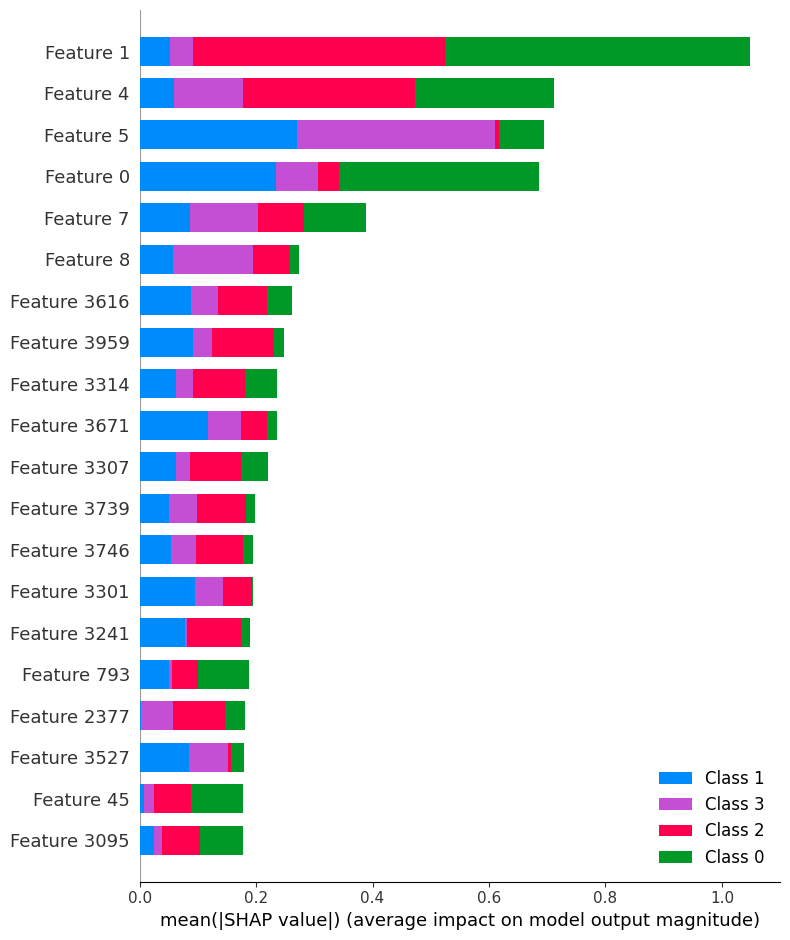

In [ ]:
from sklearn.linear_model import LogisticRegression
import shap

# Fit a logistic regression model on X_scaled
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_scaled, y)

# Create SHAP explainer
explainer = shap.Explainer(log_reg, X_scaled)
shap_values = explainer(X_scaled)

# SHAP summary plot
shap.summary_plot(shap_values, X, plot_type="bar")